# PLAsTiCC data exploration with TAPE

Let's explore [PLAsTiCC](http://plasticc.org) data!

It is publically avilable through [this Zenodo repository](https://zenodo.org/record/2539456).

In [1]:
## Uncomment to install packages

# !pip install tape joblib requests pyarrow.csv pyarrow

### Download the data

Please get the data from [Zenodo](https://zenodo.org/record/2539456) and put them to the `./plasticc` folder (you may change the location bellow with `DATA_DIR`).

In [2]:
from pathlib import Path

DATA_DIR = Path("./plasticc")

META_FILENAME = "plasticc_test_metadata.csv"
LC_FILENAMES = [f"plasticc_test_lightcurves_{i:02d}.csv" for i in range(1, 12)]
# META_FILENAME = "plasticc_train_metadata.csv.gz"
# LC_FILENAMES = ['plasticc_train_lightcurves.csv.gz']

N_PARTITIONS = len(LC_FILENAMES)

N_PROCESSORS = 4

You may skip the next cell if you already have the data downloaded in the `DATA_DIR`.

# Read and analyse the data with TAPE

In [4]:
%%time
%%memit

import light_curve as licu
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# In TAPE's (and LSST's) terminology, sources are individual detections,
# and objects are the underlying astrophysical objects.

# We load object table first, from the metadata file.
print("Loading object table...")
object_table = dd.read_csv(
    DATA_DIR / META_FILENAME,
    # Read data chunk by chunk, to avoid loading the whole file into memory.
    blocksize=100e6,
)

# Then we load the sources:
print("Loading source tables...")
source_table = dd.read_csv(
    [DATA_DIR / filename for filename in LC_FILENAMES],
    blocksize=100e6,
)

# Now we can make an Ensemble.
# To make parallel processing work we need to partition the data.
# After that, when we run analysis, TAPE will distribute the work:
# one partition per worker.
print("Building Ensemble...")
ens = Ensemble(
    n_workers=N_PROCESSORS,
)
ens.from_dask_dataframe(
    source_frame=source_table,
    object_frame=object_table,
    npartitions=None,
    column_mapper=ColumnMapper(
        id_col='object_id',
        time_col='mjd',
        flux_col='flux',
        err_col='flux_err',
        band_col='passband',
    ),
    # TODO: Doug, please put a comment here about the following line.
    sync_tables=False,
)

# Let's run some analysis!

print("Starting analysis...")
# First, let's select only Galactic objects, by cutting on hostgal_photoz.
print("First, filter by photoz")
ens = ens.query("hostgal_photoz < 1e-3", table="object")

# Second, let's select persistent sources, by cutting on the duration of the light curve.
print("Extract durations")
duration = ens.batch(
    lambda time, detected: np.ptp(time[np.asarray(detected, dtype=bool)]),
    ens._time_col, 'detected_bool',
    meta=('duration', 'float64'),
    use_map=False,
    compute=False,
)
print("Assign a column")
ens.assign(table="object", duration=duration)
print("Filter by duration")
ens = ens.query("duration > 366", table="object")

# Next, we use Otsu's method to split light curves into two groups:
# one with high flux, and one with low flux. Eclipsing binaries should have
# lower flux group smaller than the higher flux group, but having larger 
# variability. We use light-curve package to extract these features.
# (https://github.com/light-curve/light-curve-python)
# For simplicity, we only calculate these features for the i (3) band.
print("Extract Otsu features")
otsu_features = ens.batch(licu.OtsuSplit(), band_to_calc=3, use_map=False, compute=False)
print("Assign columns")
ens = ens.assign(
    table="object",
    otsu_lower_to_all_ratio=otsu_features['otsu_lower_to_all_ratio'],
    otsu_std_lower=otsu_features['otsu_std_lower'],
    otsu_std_upper=otsu_features['otsu_std_upper'],
)
print('Filter by Otsu features')
ens = ens.query(
    "otsu_lower_to_all_ratio < 0.1 and otsu_std_lower > otsu_std_upper",
    table="object",
)
print("Compute object table")
ens = ens.compute("object")

Loading object table...
Loading source tables...
Building Ensemble...


/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59176 instead
  warnings.warn(


Starting analysis...
First, filter by photoz
Extract durations
Assign a column
Filter by duration
Extract Otsu features


2023-10-18 17:25:02,409 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.79 GiB -- Worker memory limit: 8.00 GiB


Assign columns
Filter by Otsu features
Compute object table


2023-10-18 17:26:04,641 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.46 GiB -- Worker memory limit: 8.00 GiB
2023-10-18 17:26:15,915 - distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:59180'. Reason: nanny-close
2023-10-18 17:26:15,916 - distributed.nanny - INFO - Nanny asking worker to close. Reason: nanny-close
2023-10-18 17:26:15,917 - distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:59181'. Reason: nanny-close
2023-10-18 17:26:15,917 - distributed.nanny - INFO - Nanny asking worker to close. Reason: nanny-close
2023-10-18 17:26:15,918 - distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:59182'. Reason: nanny-close
2023-10-18 17:26:15,918 - distributed.nanny - INFO - Nanny asking worker to close. Reason: nanny

peak memory: 706.58 MiB, increment: 33.88 MiB
CPU times: user 7.76 s, sys: 2.38 s, total: 10.1 s
Wall time: 1min 34s


### Do the same, but with Pandas + joblib

The workflow is challenger here: we don't like to load all the light curves into memory (~20 GBi), so we have to manually jump between object table processing and source table processing.

NB: We also need `pyarrow.csv`, but only to read CSVs faster into pandas data-frames.

In [5]:
ens

,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,...,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y,duration,otsu_lower_to_all_ratio,otsu_std_lower,otsu_std_upper
object_id,,,,,,,,,,,,,,,,,,,,,
1040934,192.1674,-46.3751,0,-9.0,0.0,0.0,-9.0,0.083,0,65,...,5.7,33.7,110.5,539.1,1183.9,1991.1,410.0927,0.090909,10.038970,7.000799
1145188,104.4141,-12.1773,0,-9.0,0.0,0.0,-9.0,0.625,0,16,...,341.5,3106.7,3207.9,2379.2,1631.3,717.8,1073.9476,0.090909,111.621817,67.960107
1184639,326.9531,-22.8314,0,-9.0,0.0,0.0,-9.0,0.032,0,16,...,2114.8,19954.1,20819.5,15006.2,9573.4,3997.2,728.8966,0.086957,563.869493,25.370866
1226593,48.5156,-32.2662,0,-9.0,0.0,0.0,-9.0,0.014,0,65,...,15.0,25.1,43.4,140.4,285.6,467.0,830.8233,0.080000,12.008922,4.690816
1227515,183.3398,-16.9578,0,-9.0,0.0,0.0,-9.0,0.049,0,16,...,733.2,11232.6,16446.4,14553.2,10543.4,4789.5,1056.0646,0.095238,765.642029,122.818703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130633244,152.9297,-12.4828,0,-9.0,0.0,0.0,-9.0,0.058,0,16,...,232.1,1957.9,1864.3,1267.8,781.9,319.2,1086.8704,0.080000,57.311277,12.255049
130634660,36.8182,-46.7685,0,-9.0,0.0,0.0,-9.0,0.014,0,16,...,51.2,379.4,331.9,214.8,128.2,51.3,839.7401,0.080000,8.145193,7.080347
130708654,95.0977,-36.0536,0,-9.0,0.0,0.0,-9.0,0.052,0,16,...,2059.7,20970.8,23290.0,17505.6,11486.4,4893.3,1008.0936,0.095238,1425.256064,480.315334


### Do the same but with Pandas + joblib

In [3]:
%%time

import light_curve as licu
import numpy as np
import pandas as pd
import pyarrow
from joblib import Parallel, delayed

# Set number of threads to use when reading CSVs
pyarrow.set_cpu_count(N_PROCESSORS)
pyarrow.set_io_thread_count(N_PROCESSORS)

# First we load object table, from the metadata file.
print("Loading object table...")
object_table = pd.read_csv(DATA_DIR / META_FILENAME, engine='pyarrow', index_col='object_id')

print("Pre-filter object table")
# Before doing light-curve analysis we select only Galactic objects, by cutting on hostgal_photoz.
object_table = object_table[object_table['hostgal_photoz'] < 1e-3]


def read_source_table(filename):
    # We are going to read in parallel, so we set single thread 
    pyarrow.set_cpu_count(1)
    pyarrow.set_io_thread_count(1)
    return pd.read_csv(filename, engine='pyarrow', index_col='object_id')


def process_source_table(filename):
    source_table = read_source_table(filename)
    
    # Select sources for objects left
    source_table = source_table[source_table.index.isin(object_table.index)]
    
    # Select persistent sources, by cutting on the duration of the light curve.
    detections = source_table[source_table['detected_bool'].astype(bool)]
    # We need to group detections by object_id, to get light curves:
    durations = detections['mjd'].groupby(level=0).apply(np.ptp)
    
    # Then we filter the source table to keep only persistent sources:
    source_table = source_table.loc[durations[durations > 366].index]
    
    # Next, we use Otsu's method to split light curves into two groups:
    # one with high flux, and one with low flux. Eclipsing binaries should have
    # lower flux group significantly smaller than the higher flux group,
    # but having larger variability.
    # We use light-curve package to extract these features.
    # (https://github.com/light-curve/light-curve-python)
    # For simplicity, we only calculate these features for the i (3) band.
    
    otsu_split = licu.OtsuSplit()
    # i_band_sources = source_table[source_table['passband'] == 3]
    otsu_features = source_table[['mjd', 'flux', 'flux_err', 'passband']].groupby(level=0).apply(lambda row: pd.Series(
        otsu_split(
            np.asarray(row['mjd']),
            np.asarray(row['flux']),
            np.asarray(row['flux_err']),
            sorted=True,
            check=False,
        ),
        index=otsu_split.names,
    ))
    
    # And filter by Otsu features
    otsu_idx = (otsu_features['otsu_lower_to_all_ratio'] < 0.1) & (otsu_features['otsu_std_lower'] > otsu_features['otsu_std_upper'])
    
    return source_table.loc[otsu_idx.index[otsu_idx]]


# Running the main part of the analysis in parallel
print("Run analysis in parallel...")
source_tables = Parallel(n_jobs=N_PROCESSORS)(
    delayed(process_source_table)(DATA_DIR / filename) for filename in LC_FILENAMES
)
source_table = pd.concat(source_tables, ignore_index=False, sort=True)
object_table = object_table.loc[np.unique(source_table.index)]
object_table

Loading object table...
Pre-filter object table
Run analysis in parallel...


/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 2.83 s, sys: 2.89 s, total: 5.72 s
Wall time: 1min 4s


,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
object_id,,,,,,,,,,,,,,,,,,,,,
1040934,192.1674,-46.3751,0,-9.0,0.0,0.0,-9.0,0.083,0,65,...,0.0,0.0,59570.0,9868,5.7,33.7,110.5,539.1,1183.9,1991.1
1145188,104.4141,-12.1773,0,-9.0,0.0,0.0,-9.0,0.625,0,16,...,0.0,0.0,59570.0,48177,341.5,3106.7,3207.9,2379.2,1631.3,717.8
1184639,326.9531,-22.8314,0,-9.0,0.0,0.0,-9.0,0.032,0,16,...,0.0,0.0,59570.0,23011,2114.8,19954.1,20819.5,15006.2,9573.4,3997.2
1226593,48.5156,-32.2662,0,-9.0,0.0,0.0,-9.0,0.014,0,65,...,0.0,0.0,59570.0,27347,15.0,25.1,43.4,140.4,285.6,467.0
1227515,183.3398,-16.9578,0,-9.0,0.0,0.0,-9.0,0.049,0,16,...,0.0,0.0,59570.0,29428,733.2,11232.6,16446.4,14553.2,10543.4,4789.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130633244,152.9297,-12.4828,0,-9.0,0.0,0.0,-9.0,0.058,0,16,...,0.0,0.0,59570.0,38515,232.1,1957.9,1864.3,1267.8,781.9,319.2
130634660,36.8182,-46.7685,0,-9.0,0.0,0.0,-9.0,0.014,0,16,...,0.0,0.0,59570.0,39616,51.2,379.4,331.9,214.8,128.2,51.3
130708654,95.0977,-36.0536,0,-9.0,0.0,0.0,-9.0,0.052,0,16,...,0.0,0.0,59570.0,17929,2059.7,20970.8,23290.0,17505.6,11486.4,4893.3


# TODO
### Redo without having everything in-memory
### Add polars example

### Do the same, but with Pandas+PyArrow w/ nested arrays for dataframes, and joblib for parallelism

In [5]:
%%time

import light_curve as licu
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.csv as pacsv
from joblib import Parallel, delayed

# Read the data
# -------------

# First we load object table, from the metadata file.
print("Loading object table...")
object_table = pacsv.read_csv(
    DATA_DIR / META_FILENAME,
    # We'd like to load the whole file into a single partition
    read_options=pacsv.ReadOptions(block_size=(1<<31)-1),
)
object_table = pd.DataFrame(
    {
        col: pd.Series(
            object_table[col],
            dtype=pd.ArrowDtype(object_table[col].type),
            index=object_table['object_id'],
            copy=False,
        )
        for col in object_table.column_names if col != 'object_id'
    },
)

def read_source_table(filename):
    table = pacsv.read_csv(
        DATA_DIR / filename,
        # We'd like to have a partition per an original file
        read_options=pacsv.ReadOptions(block_size=(1<<31)-1),
    )
    return pd.DataFrame(
        {
            col: pd.Series(
                table[col],
                dtype=pd.ArrowDtype(table[col].type),
                index=table['object_id'],
                copy=False,
            )
            for col in table.column_names if col != 'object_id'
        },
    )

# source_tables = []
# for filename in LC_FILENAMES:
#     source_table = pa.csv.read_csv(
#         DATA_DIR / filename,
#         # We'd like to have a partition per an original file
#         read_options=pa.csv.ReadOptions(block_size=(1<<31)-1),
#     )
#     source_tables.append(pd.DataFrame(
#         {
#             col: pd.Series(
#                 source_table[col],
#                 dtype=pd.ArrowDtype(source_table[col].type),
#                 index=source_table['object_id'],
#                 copy=False,
#             )
#             for col in source_table.column_names if col != 'object_id'
#         },
#     ))
source_tables = Parallel(backend='threading', n_jobs=N_PROCESSORS)(
    delayed(read_source_table)(filename) for filename in LC_FILENAMES
)
source_table = pd.concat(source_tables, ignore_index=True, sort=False)


# Add sources to the object table
# -------------------------------

# First, let's do some sanity checks
print("Sanity checks...")
np.testing.assert_array_equal(
    object_table.index.values,
    np.unique(object_table.index.values),
    err_msg="Object table has duplicate indices or is not sorted.",
)
assert np.all(np.diff(source_table.index) >= 0), "Source table index must be sorted."

# We need an offsets array to know where each source light curve starts.
source_offsets = []
for table in source_tables:
    offset = np.nonzero(np.diff(table.index, prepend=-1, append=-1))[0]
    source_offsets.append(pa.array(offset))

# Update the object table with list-arrays built from the source table

print("Updating object table with list-arrays...")
for column in source_table.columns:
    list_arrays = []
    for table, offset in zip(source_tables, source_offsets):
        list_arrays.append(pa.ListArray.from_arrays(
            offset,
            pa.array(table[column]),
        ))
    chunked_array = pa.chunked_array(list_arrays)
    object_table[column] = pd.Series(
        chunked_array,
        dtype=pd.ArrowDtype(chunked_array.type),
        index=object_table.index,
    )
    
# Do analysis
# -----------

print("Starting analysis...")
# First, let's select only Galactic objects, by cutting on hostgal_photoz.
df = object_table[object_table['hostgal_photoz'] < 1e-3]

# Second, let's select persistent sources, by cutting on the duration of the light curve.
df['duration'] = df[['mjd', 'detected_bool']].apply(
    lambda row: np.ptp(row['mjd'][np.asarray(row['detected_bool'], dtype=bool)]),
    axis=1
)
df = df[df['duration'] > 366]

# Next, we use Otsu's method to split light curves into two groups:
# one with high flux, and one with low flux. Eclipsing binaries should have
# lower flux group significantly smaller than the higher flux group,
# but having larger variability.
# We use light-curve package to extract these features.
# (https://github.com/light-curve/light-curve-python)
# For simplicity, we only calculate these features for the i band.
def extract_band(*arrays, bands, band_to_calc):
    mask = np.asarray(bands) == band_to_calc
    return [np.asarray(arr)[mask] for arr in arrays]

otsu_split = licu.OtsuSplit()
otsu_features = df[['mjd', 'flux', 'flux_err', 'passband']].apply(
    lambda row: pd.Series(
        otsu_split(
            *extract_band(
                row['mjd'],
                row['flux'],
                row['flux_err'],
                bands=row['passband'],
                band_to_calc=3,  # i band
            ),
            sorted=True,
            check=False,
        ),
        index=otsu_split.names,
    ),
    axis=1
)

df = df[otsu_features['otsu_lower_to_all_ratio'] < 0.1]
df = df[otsu_features['otsu_std_lower'] > otsu_features['otsu_std_upper']]
df

Loading object table...
Loading source tables...
Sanity checks...
Updating object table with list-arrays...
Starting analysis...


<string>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


peak memory: 15626.92 MiB, increment: 14968.31 MiB
CPU times: user 1min 38s, sys: 34.6 s, total: 2min 13s
Wall time: 2min 18s


<string>:156: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


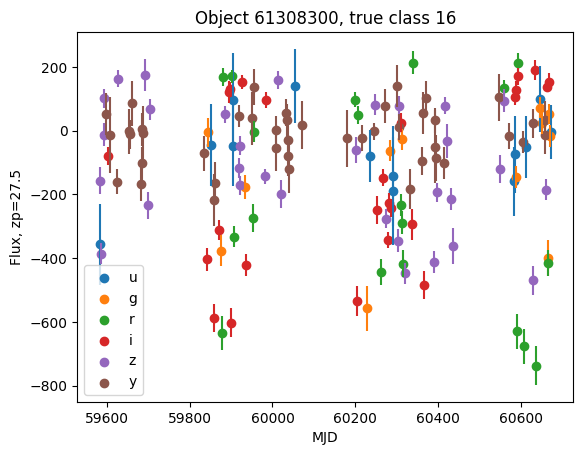

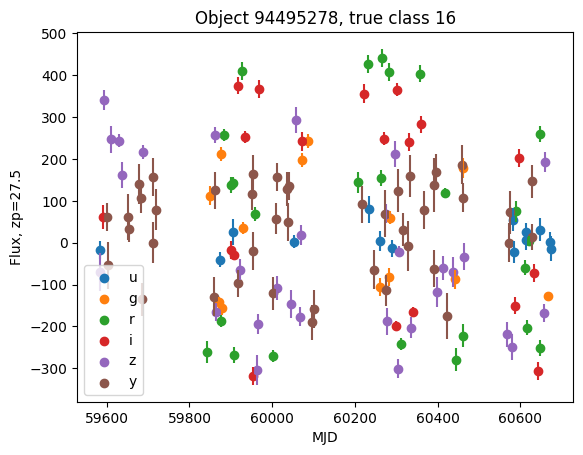

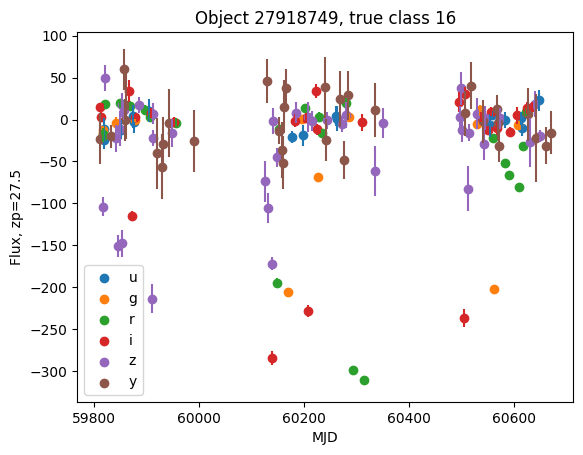

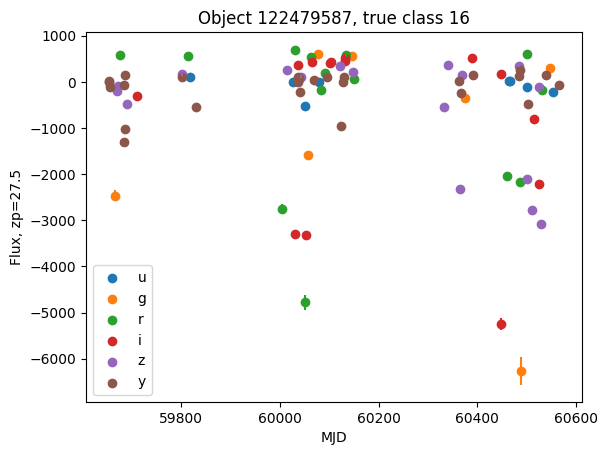

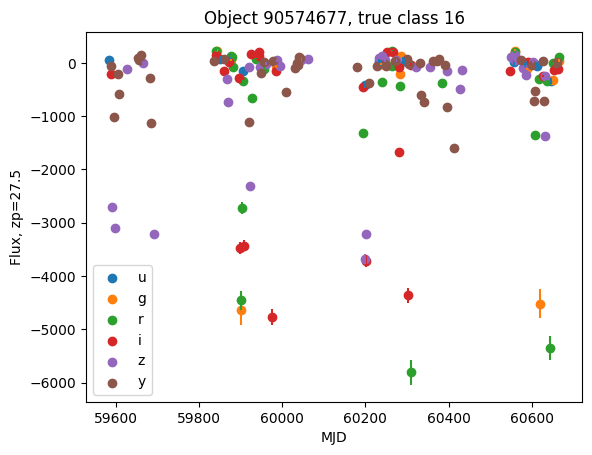

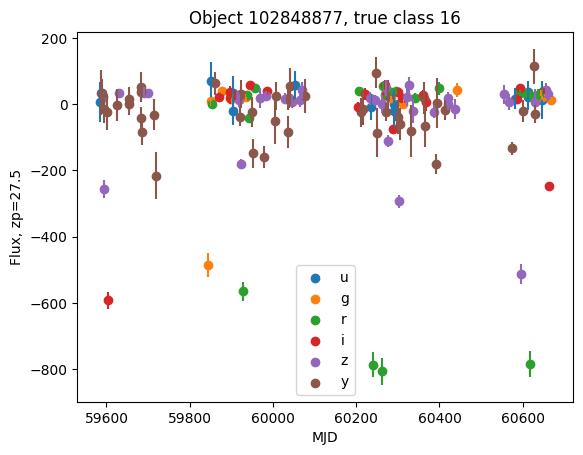

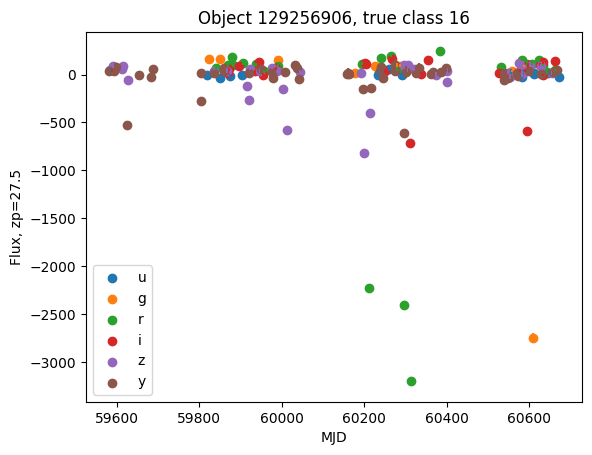

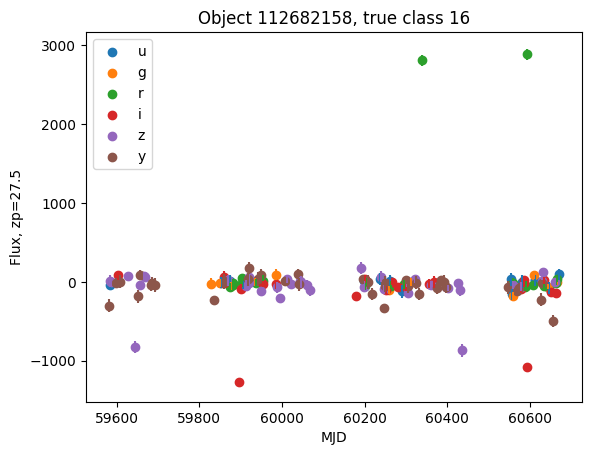

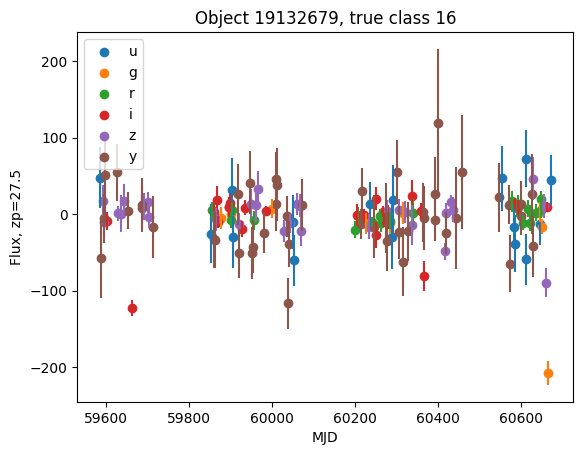

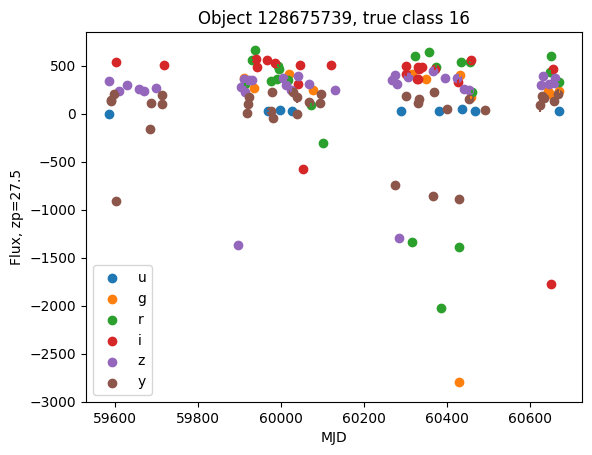

In [6]:
import matplotlib.pyplot as plt

LSST_BANDS = 'ugrizy'

def plot(row):
    plt.figure()
    plt.title(f"Object {row.Index}, true class {row.true_target}")
    plt.xlabel('MJD')
    plt.ylabel('Flux, zp=27.5')
    for band_idx, band_name in enumerate(LSST_BANDS):
        mjd, flux, flux_err = extract_band(
            row.mjd,
            row.flux,
            row.flux_err,
            bands=row.passband,
            band_to_calc=band_idx,
        )
        color = f'C{band_idx}'
        plt.scatter(mjd, flux, c=color, label=band_name)
        plt.errorbar(mjd, flux, yerr=flux_err, ls='none', c=color)
        plt.legend()

# Random objects from the selected sample
for row in object_table[object_table['true_target'] == 16].sample(5, random_state=0).itertuples():
    plot(row)
    
# Random objects from the selected sample
for row in df.sample(5, random_state=0).itertuples():
    plot(row)